# Bayes-by-Backprop and Pruning with Alchemy, TensorFlow (and Sonnet)

In [1]:
!git clone -b experimental https://git@github.com/wenkesj/alchemy.git ~/alchemy
!(cd ~/alchemy; pip install -q .)
!pip install -q dm-sonnet observations tqdm

Cloning into '/content/alchemy'...
remote: Counting objects: 274, done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 274 (delta 143), reused 219 (delta 88), pack-reused 0
Receiving objects: 100% (274/274), 62.63 KiB | 8.95 MiB/s, done.
Resolving deltas: 100% (143/143), done.


Bayes by Backprop is an algorithm for learning a distribution
over neural network weights.

In [0]:
import alchemy as ay
import tensorflow as tf; tf.set_random_seed(1)
import sonnet.python.custom_getters.bayes_by_backprop as bbb

prior_builder, posterior_builder = ay.utils.custom_scale_mixture_prior_factory(
    pi=.01, sigma1=.25, sigma2=.01)

sampling_mode_ph = tf.placeholder(tf.string, [])

get_bbb_variable_fn = bbb.bayes_by_backprop_getter(
    posterior_builder=posterior_builder,
    prior_builder=prior_builder,
    kl_builder=bbb.stochastic_kl_builder,
    sampling_mode_tensor=sampling_mode_ph)

# Defining the Problem
This uses the **MNIST** dataset.

In [0]:
from observations import mnist

(x_train, y_train), (x_test, y_test) = mnist('data')
train_size, test_size = len(x_train), len(x_test)

# Defining the Model

In [0]:
inputs_ph = tf.placeholder(tf.float32, [None, 784])
labels_ph = tf.placeholder(tf.int32, [None])

def model_fn(inputs_ph):
  inputs = tf.reshape(inputs_ph, [tf.shape(inputs_ph)[0], 28, 28, 1])
  y = tf.layers.conv2d(tf.cast(inputs, tf.float32) / 127, 32, (3, 3), 
                       activation=tf.nn.relu)
  y = tf.layers.conv2d(y, 64, (3, 3), activation=tf.nn.relu)
  y = tf.contrib.layers.flatten(y)
  y = tf.layers.dense(
      y, units=128,
      activation=tf.nn.relu)
  y = tf.layers.dense(
      y, units=10)
  return y

Create the training network using the getter

In [0]:
bbb_scope = 'bbb'
with tf.variable_scope(bbb_scope, custom_getter=get_bbb_variable_fn) as vs:
  bbb_logits = model_fn(inputs_ph)

Create the pruning op

In [0]:
metadata = bbb.get_variable_metadata()
total_variables = sum([ay.utils.product(meta.raw_variable_shape) 
                       for meta in metadata])
percentage_ph = tf.placeholder(tf.float32, [])
pruned_vars_op = ay.contrib.train.prune_by_bbb(metadata, percentage_ph)

Minimize the total loss

In [0]:
with tf.variable_scope(bbb_scope):
  loss_op = tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=labels_ph, logits=bbb_logits, name='loss'),
      axis=-1)

  loss_op += bbb.get_total_kl_cost() / train_size
  train_op = tf.train.AdamOptimizer(1e-3).minimize(loss_op)

`bbb` validation criterion

In [0]:
bbb_pred_op = tf.cast(tf.argmax(bbb_logits, axis=-1), tf.int32)
bbb_accy_op = tf.reduce_mean(
    tf.cast(tf.equal(bbb_pred_op, labels_ph), tf.float32), axis=-1)

Create the pruned network template

In [0]:
template_scope = 'template'
with tf.variable_scope(template_scope) as vs:
  template_logits = model_fn(inputs_ph)

`template` validation criterion

In [0]:
template_pred_op = tf.cast(tf.argmax(template_logits, axis=-1), tf.int32)
template_accy_op = tf.reduce_mean(
    tf.cast(tf.equal(template_pred_op, labels_ph), tf.float32), axis=-1)

Retrieve the variables so we can prune them in-place. In other words, find the variables from `'bbb'` that correspond to `'template'`

In [0]:
template_variables = tf.trainable_variables(scope=template_scope)
assign_pruned_vars_op = ay.contrib.train.assign_pruned_by_bbb_to_template(
    metadata, pruned_vars_op, template_variables,
    from_scope=bbb_scope, to_scope=template_scope)

Another (viable) inspiration of using BBB is the ability to use a pre-trained model and then prune it, getting similar results. 

This can be accomplished with very little work by using the fact that the pruned model's weights are sampled from the **mean** of the distributions. With this assumption, you can take the pre-trained weights and set those as the **mean**s of the BBB model and (only or maybe not, need to write a paper on the results **¯\_(ツ)_/¯**) train the **variance** to get the **SNR**.

In [0]:
# using a pre-trained model, and comment below this
# assign_template_vars_op = ay.contrib.train.assign_template_to_prune_by_bbb(
#     template_variables, metadata,
#     from_scope=template_scope, to_scope=bbb_scope)

with tf.variable_scope(template_scope):
  template_loss_op = tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=labels_ph, logits=template_logits, name='loss'),
      axis=-1)
  # using a pre-trained model, and comment below this
  # template_train_op = tf.train.AdamOptimizer(1e-3).minimize(template_loss_op)

# Baseline Training and Validation

In [13]:
import sys
from tqdm import trange

batch_size = 64
num_epochs = 1

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for epoch in range(num_epochs):
  train_loss = 0.
  train_set = ay.utils.generate_dataset((x_train, y_train), batch_size)
  train_msg = 'Epoch {} mean train loss = {:.4f}'
  train_range = trange(
      train_size // batch_size, 
      desc=train_msg.format(epoch, train_loss),
      file=sys.stdout)
  for _ in train_range:
    x, y = next(train_set)
    # using a pre-trained model, and comment below this
    # train_loss, _ = sess.run((template_loss_op, template_train_op), feed_dict={
    #     inputs_ph: x,
    #     labels_ph: y,
    # })
    train_loss, _ = sess.run((loss_op, train_op), feed_dict={
        inputs_ph: x,
        labels_ph: y, 
        sampling_mode_ph: bbb.EstimatorModes.sample,
    })
    train_range.set_description(train_msg.format(epoch, train_loss))

  test_accy = 0.
  test_set = ay.utils.generate_dataset((x_test, y_test), batch_size)
  for test_steps_taken in range(test_size // batch_size):
    x, y = next(test_set)
    # using a pre-trained model, and comment below this
    # test_accy += sess.run(template_accy_op, feed_dict={
    #     inputs_ph: x,
    #     labels_ph: y,
    # })
    test_accy += sess.run(bbb_accy_op, feed_dict={
        inputs_ph: x,
        labels_ph: y,
        sampling_mode_ph: bbb.EstimatorModes.mean,
    })
  print('Accy {:.2f}%'.format(100. * (test_accy / (test_steps_taken + 1))))

# using a pre-trained model, uncomment this
# sess.run(assign_template_vars_op)

Epoch 0 mean train loss = 19.7494: 100%|██████████| 937/937 [00:57<00:00, 16.34it/s]
Accy 89.22%


# Prune and validate

In [14]:
import numpy as np; np.random.seed(1)

pruning_percentages = [
    0., .75, .85, .9, .95, .975, .99, 1.]
pruning_accys = []

# using a pre-trained model, uncomment this
# train_loss = 0.
# train_set = ay.utils.generate_dataset((x_train, y_train), batch_size)
# train_msg = 'Epoch {} mean train loss = {:.4f}'
# train_range = trange(
#     train_size // batch_size, 
#     desc=train_msg.format(epoch, train_loss),
#     file=sys.stdout)
# for _ in train_range:
#   x, y = next(train_set)
#   train_loss, _ = sess.run((loss_op, train_op), feed_dict={
#       inputs_ph: x,
#       labels_ph: y, 
#       sampling_mode_ph: bbb.EstimatorModes.sample,
#   })
#   train_range.set_description(train_msg.format(epoch, train_loss))

for percentage in pruning_percentages:
  sess.run(
      assign_pruned_vars_op, feed_dict={
          percentage_ph: percentage,
          sampling_mode_ph: bbb.EstimatorModes.mean,
      })
  test_accy = 0.
  test_set = ay.utils.generate_dataset((x_test, y_test), batch_size)
  for test_steps_taken in range(test_size // batch_size):
    x, y = next(test_set)
    test_accy += sess.run(template_accy_op, feed_dict={
        inputs_ph: x,
        labels_ph: y,
    })
  
  print()
  sparse_variables = sess.run(template_variables)
  for sparse, tfsparse in zip(sparse_variables, template_variables):
    nnz = np.count_nonzero(sparse)
    n = ay.utils.product(sparse.shape)
    print("{}: total nonzero {:d}/{:d} = {:.2f}%".format(
        tfsparse.name, int(nnz), int(n), nnz / n * 100.))

  pruning_accy = 100. * (test_accy / (test_steps_taken + 1))
  pruning_accys.append(pruning_accy)
  print('Epoch {} accy of pruning {:.2f}% = {:.2f}%'.format(
      epoch, 100. * percentage, pruning_accy))
  print()


template/conv2d/kernel:0: total nonzero 288/288 = 100.00%
template/conv2d/bias:0: total nonzero 32/32 = 100.00%
template/conv2d_1/kernel:0: total nonzero 18432/18432 = 100.00%
template/conv2d_1/bias:0: total nonzero 64/64 = 100.00%
template/dense/kernel:0: total nonzero 4718592/4718592 = 100.00%
template/dense/bias:0: total nonzero 128/128 = 100.00%
template/dense_1/kernel:0: total nonzero 1280/1280 = 100.00%
template/dense_1/bias:0: total nonzero 10/10 = 100.00%
Epoch 0 accy of pruning 0.00% = 89.22%


template/conv2d/kernel:0: total nonzero 284/288 = 98.61%
template/conv2d/bias:0: total nonzero 30/32 = 93.75%
template/conv2d_1/kernel:0: total nonzero 17794/18432 = 96.54%
template/conv2d_1/bias:0: total nonzero 14/64 = 21.88%
template/dense/kernel:0: total nonzero 1165290/4718592 = 24.70%
template/dense/bias:0: total nonzero 29/128 = 22.66%
template/dense_1/kernel:0: total nonzero 1261/1280 = 98.52%
template/dense_1/bias:0: total nonzero 5/10 = 50.00%
Epoch 0 accy of pruning 75.00% =

# Pruning visualization

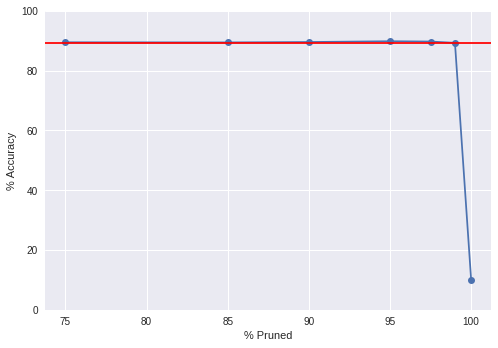

In [15]:
import matplotlib.pyplot as plt

plt.ylabel('% Accuracy')
plt.xlabel('% Pruned')
plt.ylim([0, 100.])
_ = plt.plot(
    np.asarray(pruning_percentages[1:]) * 100., pruning_accys[1:], marker='o')
_ = plt.axhline(y=pruning_accys[0], color='r', linestyle='-')

# BONUS: Train after pruning

In [0]:
template_optimizer = ay.contrib.train.SparseVariableOptimizer(
    tf.train.AdamOptimizer(1e-3))
grads_and_vars = template_optimizer.compute_gradients(
    template_loss_op, template_variables)
template_train_op = template_optimizer.apply_gradients(grads_and_vars)
template_optimizer_init_op = template_optimizer.get_initializer(
    template_variables)

In [17]:
sess.run(
    assign_pruned_vars_op, feed_dict={
        percentage_ph: .99,
        sampling_mode_ph: bbb.EstimatorModes.mean,
    })

num_re_epochs = 1
sess.run(template_optimizer_init_op)
for epoch in range(num_re_epochs):
  train_loss = 0.
  train_set = ay.utils.generate_dataset((x_train, y_train), batch_size)
  train_msg = 'Epoch {} mean train loss = {:.4f}'
  train_range = trange(
      train_size // batch_size, 
      desc=train_msg.format(epoch, train_loss),
      file=sys.stdout)
  for _ in train_range:
    x, y = next(train_set)
    train_loss, _ = sess.run((template_loss_op, template_train_op), feed_dict={
        inputs_ph: x,
        labels_ph: y, 
    })
    train_range.set_description(train_msg.format(epoch, train_loss))

  test_accy = 0.
  test_set = ay.utils.generate_dataset((x_test, y_test), batch_size)
  for test_steps_taken in range(test_size // batch_size):
    x, y = next(test_set)
    test_accy_ = sess.run(template_accy_op, feed_dict={
        inputs_ph: x,
        labels_ph: y,
    })
    test_accy += test_accy_
  print('Accy {:.2f}%'.format(100. * (test_accy / (test_steps_taken + 1))))

Epoch 0 mean train loss = 0.3868: 100%|██████████| 937/937 [00:19<00:00, 48.49it/s]
Accy 97.89%


# Benchmark the inferencing time, just for kicks

In [18]:
import time

times = []
test_accy = 0.
test_set = ay.utils.generate_dataset((x_test, y_test), 1)
for test_steps_taken in range(test_size // 1):
  x, y = next(test_set)
  start = time.time()
  sess.run(template_logits, feed_dict={
      inputs_ph: x,
  })
  end = time.time() - start
  times.append(end)
times = np.array(times)

print('mean time = {:.5f} ms'.format(times.mean()))
print('stdv time = {:.5f} ms'.format(times.std()))
print('max time = {:.5f} ms'.format(times.max()))
print('min time = {:.5f} ms'.format(times.min()))

mean time = 0.00165 ms
stdv time = 0.00055 ms
max time = 0.05416 ms
min time = 0.00130 ms


By exploiting these zero entries, you can often reduce the storage and computational requirements to O(tau*n) and O(tau*n²) respectively, where tau is the average number of entries in each column. This reduction makes the solution of large problems (n in the millions or larger) tractable on most computers.

In [19]:
sparse_variables = sess.run(template_variables)
for sparse, tfsparse in zip(sparse_variables, template_variables):
  nnz = np.count_nonzero(sparse)
  n = ay.utils.product(sparse.shape)
  print("{}: total nonzero {:d}/{:d} = {:.2f}%".format(
      tfsparse.name, int(nnz), int(n), nnz / n * 100.))

template/conv2d/kernel:0: total nonzero 277/288 = 96.18%
template/conv2d/bias:0: total nonzero 27/32 = 84.38%
template/conv2d_1/kernel:0: total nonzero 16749/18432 = 90.87%
template/conv2d_1/bias:0: total nonzero 0/64 = 0.00%
template/dense/kernel:0: total nonzero 29100/4718592 = 0.62%
template/dense/bias:0: total nonzero 0/128 = 0.00%
template/dense_1/kernel:0: total nonzero 1234/1280 = 96.41%
template/dense_1/bias:0: total nonzero 1/10 = 10.00%
